# [Obspy](https://docs.obspy.org/): a Python Toolbox for seismology

## ROSES Tutorial Outline

1. Reading data from a file
2. Downloading data from online repositories
3. Removing instrument response
4. Writing data to a file
5. Some Obspy stream and trace methods
6. Plotting with Matplotlib

### Instructor: Sydney Dybing (sdybing@uoregon.edu)

#### Dependencies needed: Obspy, Numpy, Matplotlib

Since this lecture is only an hour, I intend for it to serve as a basic introduction to using Obspy. I've written it to include information about how to use the tools I find myself using most often in my research.

If you want to learn more or there are functions I didn't cover that you need, there are several fantastic options for learning more about Obspy online. In particular, I will link the official [Obspy Tutorial](https://docs.obspy.org/tutorial/index.html), and I also recommend the [Seismo-Live Juypter Notebooks for Seismology](https://krischer.github.io/seismo_live_build/tree/index.html), which includes an Obspy section among other topics. 

I'll start showing you some of the basic capabilities of Obspy with a sample data file that I already downloaded, and was provided on Slack. This is in miniSEED format, but Obspy can also automatically detect many other data formats, such as SAC.

## Reading data from a file

In [1]:
from obspy import read

With the read function, you basically just only need the path to the file on your computer. There are additional options, such as choosing a start and an end time to read the data in from the file, but for this example this file is only 5 minutes of data, so I'll load it as-is. You can check out the other options at the Obspy documentation page for the [read function](https://docs.obspy.org/packages/autogen/obspy.core.stream.read.html).

The data is read into a [stream object](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream).

In [2]:
st = read('B082_EHZ.mseed')
print(st)

1 Trace(s) in Stream:
PB.B082..EHZ | 2010-04-04T22:40:42.368400Z - 2010-04-04T22:45:42.358400Z | 100.0 Hz, 30000 samples


Stream objects are basically collections of trace objects, which contain the data and associated metadata. You can grab a trace from a stream element the way you would an item from a list.

In [3]:
tr = st[0]
print(tr)

PB.B082..EHZ | 2010-04-04T22:40:42.368400Z - 2010-04-04T22:45:42.358400Z | 100.0 Hz, 30000 samples


To view the data:

In [4]:
data = tr.data
print(data)

[  49   52   50 ..., 6979 7201 7440]


This is a numpy array, so you can do any operations then with this array that you normally would in Python.

To view the metadata:

In [5]:
print(tr.stats)

         network: PB
         station: B082
        location: 
         channel: EHZ
       starttime: 2010-04-04T22:40:42.368400Z
         endtime: 2010-04-04T22:45:42.358400Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 30000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 134, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 68608})


If you want to use any of these particular things, you can grab them individually as follows:

In [6]:
print(tr.stats.network)
print(tr.stats.npts)

PB
30000


You can also make simple plots of traces.

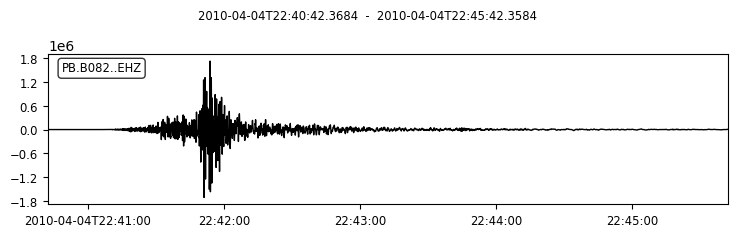

In [7]:
tr.plot();

You can change these simple Obspy plots to look more unique and plot different things. I'll go over a few basics here, and more info can be found in the [Obspy tutorial pages online](https://docs.obspy.org/tutorial/code_snippets/waveform_plotting_tutorial.html). Custom plotting with Matplotlib is more common, and I'll discuss that further later!

There are lots of different settings you can change in the plot command, such as plotting different colors and changing how axis ticks are formatted. This can be useful if you're plotting multiple things. You can also make stacked plots of data that runs for a long time using the type = 'dayplot' option. See the tutorial linked above for more information about these options! Here is an example of changing the color:

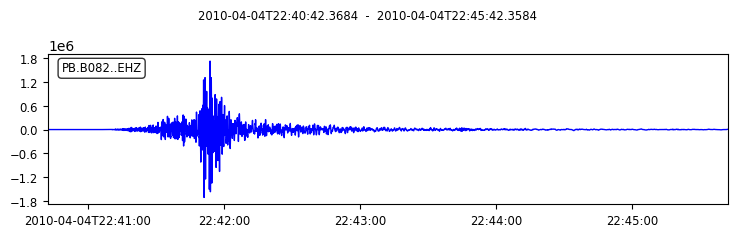

In [8]:
tr.plot(color = 'blue');

So far, we've been working with just one trace from a stream, which has a single channel of data from a single station. But often we might want to work with multiple records at a time, which can conveniently be accomplished in Obspy streams, since they can hold multiple traces. You can read them in several different ways.

First, you can add individual files to a stream one at a time.

In [9]:
st = read('CWC_HNE.mseed')
st += read('CWC_HNN.mseed')
st += read('CWC_HNZ.mseed')

print(st)

3 Trace(s) in Stream:
CI.CWC..HNE | 2019-07-05T11:06:53.048393Z - 2019-07-05T11:10:53.038393Z | 100.0 Hz, 24000 samples
CI.CWC..HNN | 2019-07-05T11:06:53.048393Z - 2019-07-05T11:10:53.038393Z | 100.0 Hz, 24000 samples
CI.CWC..HNZ | 2019-07-05T11:06:53.048393Z - 2019-07-05T11:10:53.038393Z | 100.0 Hz, 24000 samples


Another option is to read individual files in as traces, and then add them to a stream. The output is ultimately the same - you end up with a stream with three traces in it, each containing the data and associated metadata for a different channel on an instrument in this case.

In [10]:
tr1 = read('CWC_HNE.mseed')
tr2 = read('CWC_HNN.mseed')
tr3 = read('CWC_HNZ.mseed')

st = tr1 + tr2 + tr3
print(st)

3 Trace(s) in Stream:
CI.CWC..HNE | 2019-07-05T11:06:53.048393Z - 2019-07-05T11:10:53.038393Z | 100.0 Hz, 24000 samples
CI.CWC..HNN | 2019-07-05T11:06:53.048393Z - 2019-07-05T11:10:53.038393Z | 100.0 Hz, 24000 samples
CI.CWC..HNZ | 2019-07-05T11:06:53.048393Z - 2019-07-05T11:10:53.038393Z | 100.0 Hz, 24000 samples


You can make simple plots of stream objects the same way you can with traces.

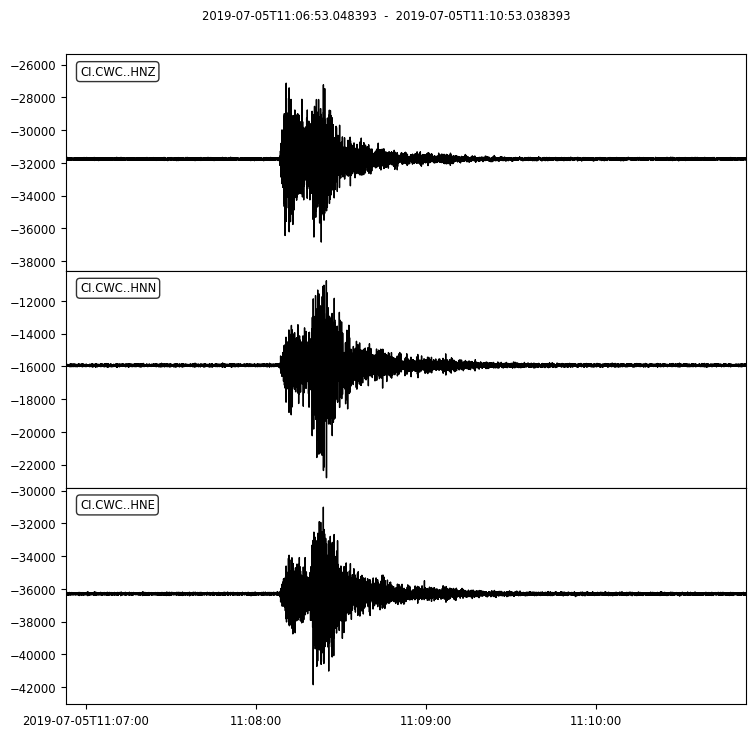

In [11]:
st.plot();

You'll notice that these numbers don't really mean anything. Right now, they're still in digital counts, and the instrument response needs to be removed to actually convert these numbers to meaningful measurements of ground motion. I'll talk more in a bit about what the "instrument response" actually is, but the great thing about the availability of online seismic data is that responses can be downloaded right alonside the data. So let's talk about downloading data from online repositories like the IRIS Data Management Center.

## Downloading data from online repositories

IRIS is just one "client" that stores data, and other client options can be found [here](https://docs.obspy.org/packages/obspy.clients.fdsn.html). [FDSN](https://www.fdsn.org/about/) is the International Federation of Digital Seismograph Networks, which helps coordinate global data access.

In [12]:
from obspy.clients.fdsn import Client

client = Client("IRIS")

The first thing that's important to know about downloading and handling data in Obspy in general is how times are managed. This is done using a class called UTCDateTime. 

In [13]:
from obspy import UTCDateTime

UTCDateTime objects are easy to use and the format is easy to understand. If you're like me and you ocassionally forget exactly how they're formatted, it's simple to check the Obspy documentation [here](https://docs.obspy.org/tutorial/code_snippets/utc_date_time.html).

The gist is that to create a UTCDateTime object, you need a year, month, and day, or a year and a julday, and a time in 24 hour clock with hour, minute, and second. This could be the origin time of an earthquake, or just the start of any time period you wish to download or examine data for. Then you just have to string them together in the right order, which is as follows:

"YYYY-MM-DDTHH:MM:SS"

If you're working in juldays, which is just counting the day of the year out of 365, with January 1 being day 001, this is the format:

"YYYY-DDDTHH:MM:SS"

Basically, the most unusual thing to remember is just to put a 'T' in between the date and the time sections of the string. 

Let's try an example. Conveniently, this is the origin time for the [M7.1 Ridgecrest earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/ci38457511/executive) last year, so we know we have a good earthquake in there to look at.

In [14]:
time = UTCDateTime("2019-07-06T03:19:53.04")
print(time)

2019-07-06T03:19:53.040000Z


You can add or subtract a number of seconds from a UTCDateTime object, which is useful for downloading a specific segment of data. Let's say we want to download the data from 1 minute before the M7.1's origin time to 15 minutes after it. Since we calculate in seconds, as you might expect you can just multiply 60 times the number of minutes you want, and the same for hours, etc.

In [15]:
starttime = time - 60 
print(starttime)

2019-07-06T03:18:53.040000Z


In [16]:
endtime = time + 60*15
print(endtime)

2019-07-06T03:34:53.040000Z


Great! We now have our two bookend times for the data we want to download. Now the question is - where do we want to get it from? Which network, which station, which location, and which channel or channels?

The widely-adopted [SEED standard](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed/) for data follows this convention for identifying where data comes from:

__Network code__: Identifies which network the data belongs to. You can check out all of the available networks at IRIS MetaData Aggregator [here](http://ds.iris.edu/mda/). Network codes are unique and assigned by the FDSN.

__Station code__: The station within a network - these aren't necessarily unique, so you need to use network codes with station codes to identify a station.

__Location ID__: Sometimes stations can have more than one instrument at them, which is specified by the location ID.

__Channel codes__: Three character code - Emily will talk more about this next week!

Let's start with a simple example, where we choose one network, one station, one location (one instrument basically that's part of the station), and one channel. This is a seismometer in the Global Seismic Network in Tucson, AZ, which is the closest GSN station to Ridgecrest. I chose this one instead of a more local seismometer to show you the IRIS MDA (Meta Data Aggregator) page, because this GSN station has different instruments listed with locations, and not all stations do this. Here is the [MDA page](http://ds.iris.edu/mda/IU/TUC/?starttime=1992-06-13&endtime=2599-12-31) for the Tucson station. 

In [17]:
net = "IU"
sta = "TUC"
loc = "00"
chan = "HH1"

To actually download the data, we can use an Obspy function called get_waveforms. All it requires is the network, station, location, channel, and start time and end time, which we already defined!

1 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples


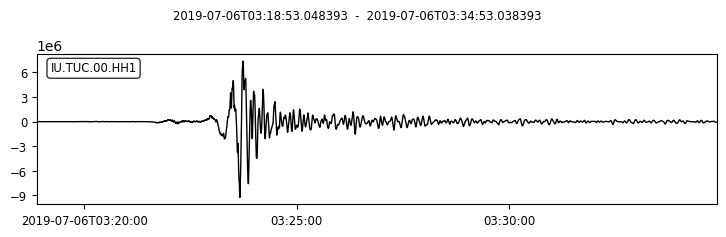

In [18]:
st = client.get_waveforms(net, sta, loc, chan, starttime, endtime)
print(st)
st.plot();

And there's the earthquake!

What if we want to download multiple channels? In Obspy you can use Linux syntax like wildcards to accomplish this. So if we want to download all three HH channels, we can do this:

3 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples
IU.TUC.00.HH2 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples
IU.TUC.00.HHZ | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples


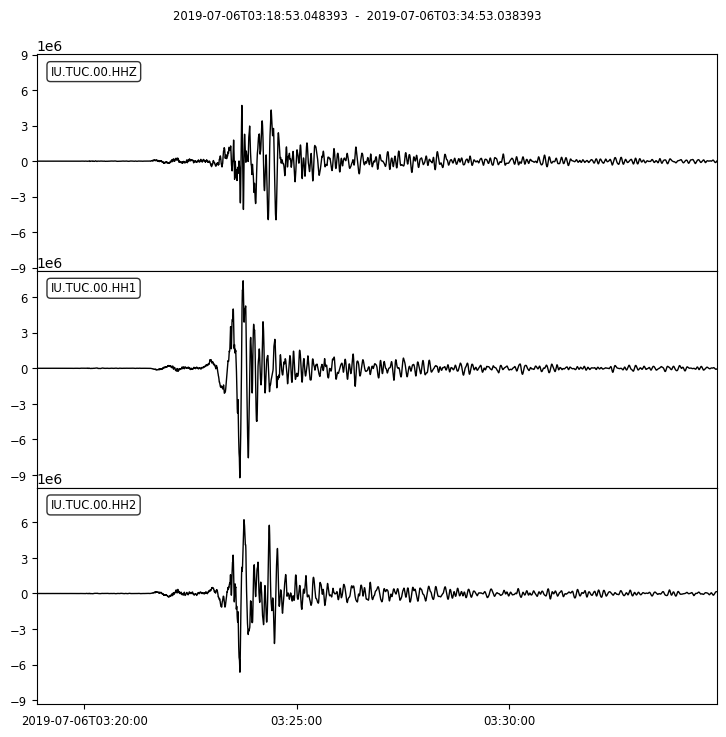

In [19]:
chan = "HH*"

st = client.get_waveforms(net, sta, loc, chan, starttime, endtime)
print(st)
st.plot();

You can also do this with locations, stations, and networks if you want, but just be aware of just how much data you might be trying to download if you decide to! It can take a long time.

## Removing instrument response

So a little while ago, I mentioned how this data right now is quantitatively meaningless. Sure, we can see that there's an earthquake, and we would be able to pick out a p-wave arrival time, but as-is this data doesn't represent actual ground motion. That's because we haven't removed the instrument response yet.

The reason we need to do this is because of the way that seismometers actually record data, which I'll give a very brief overview about.

Because in seismology we're interested in such a wide bandwidth of frequencies in the signals we record, we've had to design our instruments to be sensitive to all of these frequencies, which isn't as simple as just having a mass on a spring. The typical "picture" of a basic seismometer is an instrument that records the motion of the frame of the seismometer relative to a stationary mass - but this only gives us a limited dynamic range over which we can record. 

To increase this range, we have to use electronic feedback loops in the instruments, so we basically end up recording the voltage that is necessary to keep the mass inside the instrument stable when the ground is moving. Every seismometer is hooked up to a digitizer, which then converts this analog voltage signal to a digital record of "counts" that can be read by a computer. 

So when you download data from IRIS, what you're actually getting is a timeseries of "counts" that the digitizer for the instrument has outputted. In order to convert to actual ground velocity, we have to account for the digitizer and the response of the seismometer itself to ground motion, which is frequency-dependent.

Theoretically, this is relatively complicated, and not exactly the purpose of this tutorial, so I won't cover it here. But you can find the derivation in [Havskov and Alguacil, 2015](https://books.google.com/books?id=5PPuCgAAQBAJ&pg=PA197&lpg=PA197&dq=10.1007/978-3-319-21314-9_6&source=bl&ots=R_XJrZxu59&sig=ACfU3U2YdUF5_nlVwRFs0Hbvdm5fHI7_Xw&hl=en&sa=X&ved=2ahUKEwjc7sjft5bqAhWSJzQIHYS7A0UQ6AEwCnoECAoQAQ#v=onepage&q=10.1007%2F978-3-319-21314-9_6&f=false). In practice, Obspy makes correcting for instrument response easier! You just have to make sure you download the response with the data.

Let's keep working with the same Tucson station and the Ridgecrest earthquake. But this time, when I download the data I'll make sure to attach the instrument response. As a refresher, here are the variables we have set. We'll stick with working on one channel for now to make visualization simpler.

In [20]:
time = UTCDateTime("2019-07-06T03:19:53.04")
starttime = time - 60 
endtime = time + 60*15

net = "IU"
sta = "TUC"
loc = "00"
chan = "HH1"

Now, all we have to do is add one option when we use get_waveforms:

1 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples


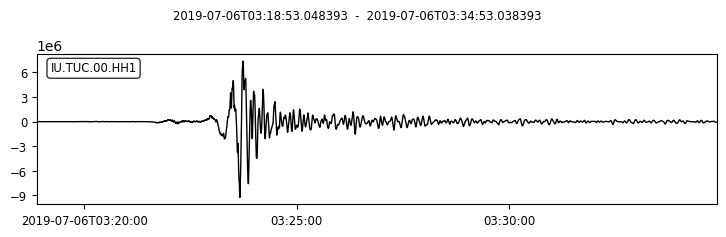

In [21]:
st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
print(st)
st.plot();

It doesn't look any different yet, but the responses have been downloaded. Before removing the response, you might want to copy your data, since the function remove_response acts directly on the data, and will overwrite the original. Copying a stream is simple:

In [22]:
st_rem = st.copy()
print(st)
print(st_rem)

1 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples
1 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples


Now we can remove the response, which can also be simple. You can set which units you want the ground motion to be represented in using the output option. As a note - here I perform the response removal on a stream, but all of these same functions can be used on individual traces!

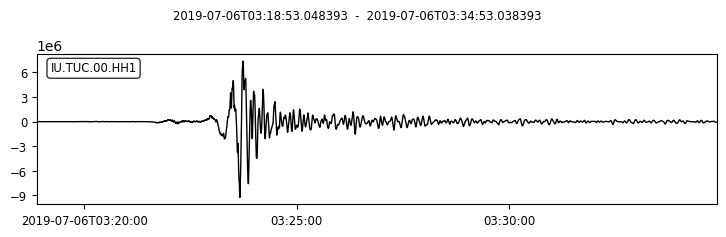

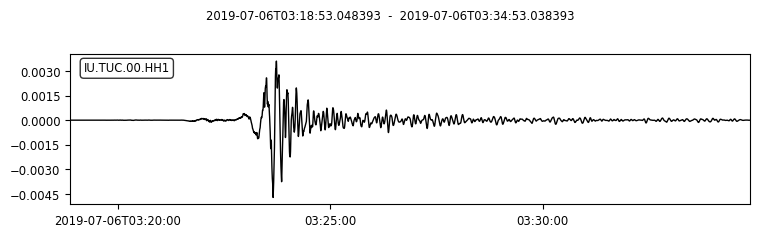

In [23]:
st_rem.remove_response(output = 'VEL') # other options: output = 'DISP', 'ACC'

st.plot()
st_rem.plot();

# Remember, if you run this cell multiple times, your output will be strange because you already removed the
# response from st_rem. If you want to do it again and try something else, you either have to make a new copy
# of the original st again, or go back and re-run the previous cell that copied st.

However, in reality what I just demonstrated is probably an oversimplification of response removal. Because data is inherently noisy, when you divide the data by the response at low and high frequencies, you end up amplifying the noise. This is why bandpass filtering is commonly done as part of the response removal process. This is particularly important if you're using an instrument that may not have a flat response at such a range of frequencies as this broadband GSN sensor does.

We can visualize what's happening in the response removal process by using the plot = True option in the remove_response function. This is what it looks like if we don't do any kind of filtering, and if you choose to use filters, the different plots will show what happens in each step. How to choose an appropriate filter for your interest is tricky, and Emily will talk about this next week in her tutorial!

1 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples

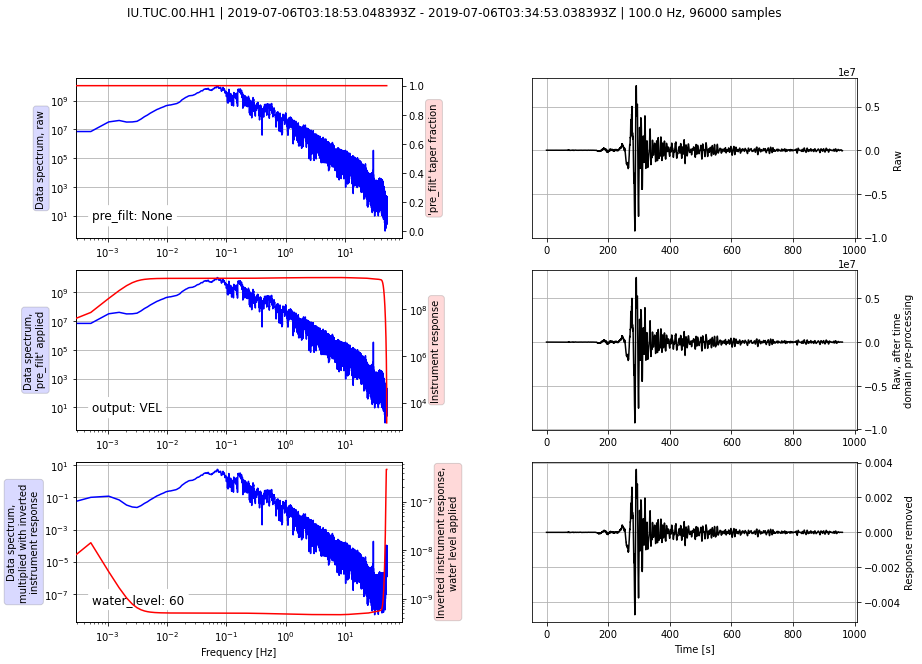

In [24]:
st_rem = st.copy() # repeating this since the last cell will have removed the response from st_rem already

st_rem.remove_response(output = 'VEL', plot = True) # other options: output = 'DISP', 'ACC'

Great! So now we have some seismic data that's had the instrument response removed, so in this case we now know we're working in units of velocity (m/s) for the ground motion. This is what it looks like now:

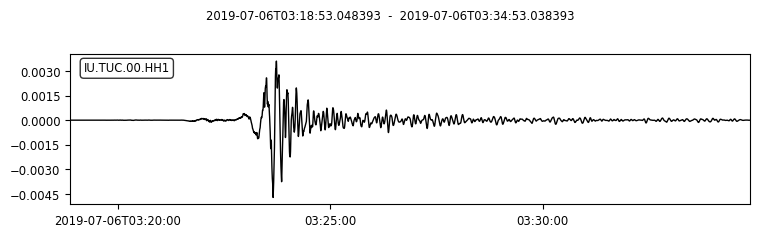

In [25]:
st_rem.plot();

## Writing downloaded data to a file

What other things might we want to do with this data? Well, one thing I always like to do is save the data that's been downloaded into miniSEED files on my computer so that I can go back to it later and work on it in other scripts. This can be done with st.write() - you just specify the desired file path, name, extension, and data format (SAC, MSEED, etc.). It looks something like this:

stream.write('/path/filename.mseed', format='MSEED')

And here's how we would implement it for this example, where I want the file to be named after the station and channel. I'm not including a path, since I just want it to be saved in the same directory as this Jupyter notebook.

In [26]:
filename = sta + '_' + chan + '.mseed'

st_rem.write(filename, format='MSEED')

/Users/sydneydybing/opt/anaconda3/envs/roses_env/lib/python3.6/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


If you ran this with me, you should be able to open up your file explorer and see your brand new miniSEED data file! Now we can read it in as a stream just as we did with the sample file at the beginning of this tutorial, and we can play around with it some more. 

         network: IU
         station: TUC
        location: 00
         channel: HH1
       starttime: 2019-07-06T03:18:53.048393Z
         endtime: 2019-07-06T03:34:53.038393Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 96000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 1715, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 878080})


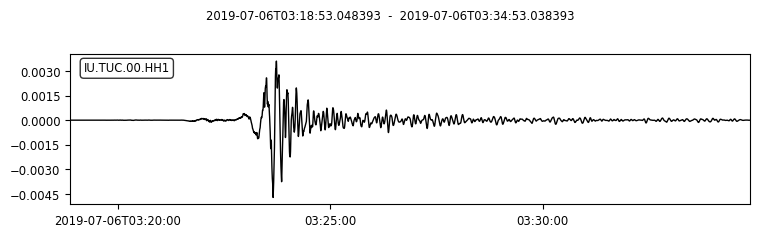

In [27]:
st = read('TUC_HH1.mseed')
print(st[0].stats)
st.plot();

## Some Stream and Trace Methods

The stream and trace objects in Obspy both have a number of public methods that can be used to modify the data. I'll go over a few of them that I use most often, and if there is anything else you're interested in doing, you can check the Obspy documentation for [traces](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html#obspy.core.trace.Trace) and for [streams](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html). There are some different methods between the two types of objects, but all of the methods I'll demonstrate here on a stream can also be used on individual traces. 

### Filtering

One thing we might want to do is look at a specific frequency range of data in our earthquake. We can use the "filter" method for this. There are many different filter methods available: 

1. bandpass
2. bandstop
3. lowpass
4. highpass
5. lowpass_cheby_2
6. lowpass_fir (experimental)
7. remez_fir (experimental)

Information about all of these options can be found in the Obspy documentation [here](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html#obspy.core.stream.Stream.filter). For each filter, you'll have to specify which frequency or frequencies to use depending on the type of filter.

Similar to remove_response, the filtering operation is performed on the original data, so make sure to make a copy of your stream first if you want to retain the unfiltered data.

Let's try a bandpass example. For this example, let's say we're only interested in looking at the band of data between 1 and 20Hz. You can just define the filter limits as such:

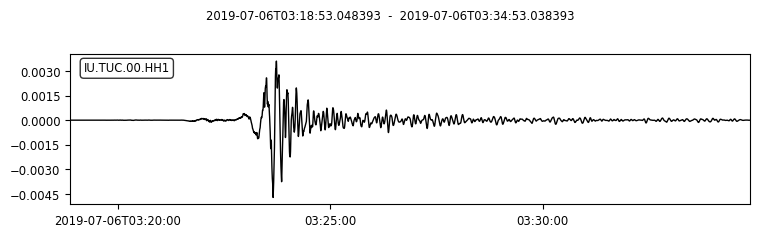

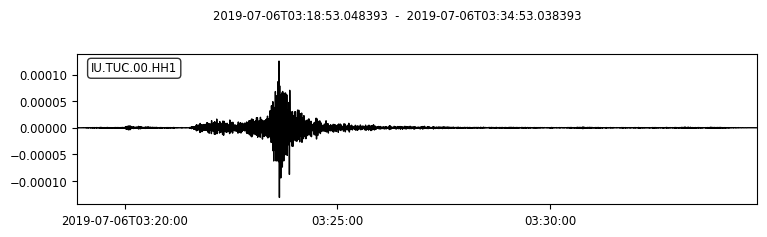

In [28]:
st_filt = st.copy()

st_filt.filter("bandpass", freqmin=1.0, freqmax=20.0)

st.plot()
st_filt.plot();

And there we have it! You can then continue to work on this stream, or write it to a new data file like I explained earlier.

### Trimming data

Let's say that now we no longer care about the data in this stream outside of the main earthquake, and we want to shorten our stream. This can be accomplished with the ["trim"](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.trim.html#obspy.core.stream.Stream.trim) method. For this method, you need UTCDateTime objects for the time you want your new trimmed trace to start and end. 

So let's look at what the times are for this data stream. We defined it above when we downloaded it, but if you didn't have this available, you can always check the stats for an individual trace and grab the times from there - and they're conveniently already in UTCDateTime format!

In [29]:
print(st[0].stats)

         network: IU
         station: TUC
        location: 00
         channel: HH1
       starttime: 2019-07-06T03:18:53.048393Z
         endtime: 2019-07-06T03:34:53.038393Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 96000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 1715, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 878080})


So let's say we want to chop 6 minutes off the end of this trace, and 2 minutes off the front.

In [30]:
starttime = st[0].stats.starttime + 2*60
endtime = st[0].stats.endtime - 6*60

Don't forget to copy the stream again if you want to keep the original.

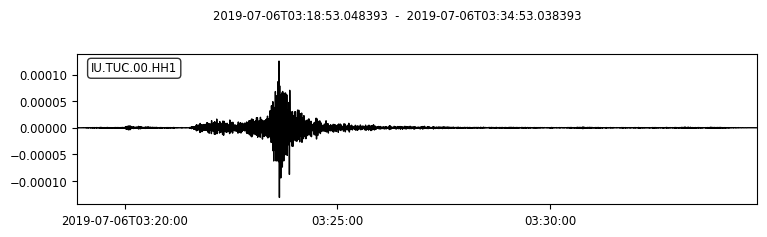

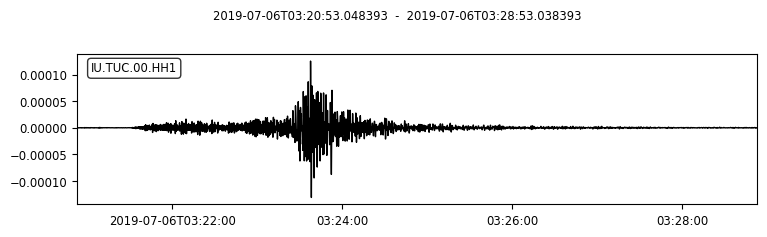

In [31]:
st_trim = st_filt.copy()

st_trim.trim(starttime=starttime, endtime=endtime)

st_filt.plot()
st_trim.plot();

Now we could save this as a new miniSEED file again if we wanted to. One additional option that I didn't include here that you can do while trimming data is to fill gaps with a value, and for this you just set fill_value=somenumber in the method after defining the start and end time.

### Changing sampling rates

This is the last stream/trace method I'll cover in this tutorial. There are three methods in Obspy for changing the sampling rates of data in a stream or trace:

1. [Decimate](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.decimate.html#obspy.core.stream.Stream.decimate): downsamples data by an integer factor
2. [Interpolate](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.interpolate.html#obspy.core.trace.Trace.interpolate): increase sampling rate by interpolating (many method options)
3. [Resample](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.resample.html#obspy.core.stream.Stream.resample): resamples data using a Fourier method

I'm going to demonstrate decimation here for simplicity's sake, but if you want to use one of these other methods, just check out the documentation, which I've linked! Again, this operation acts on the original data, so copy it first if you want to keep it.

If you don't remember the original sampling rate, you can again check it in the stats. This will help you choose what factor to decimate by.

In [32]:
st_trim[0].stats.sampling_rate

100.0

The original sampling rate was 100Hz, so let's decimate by a factor of 10.

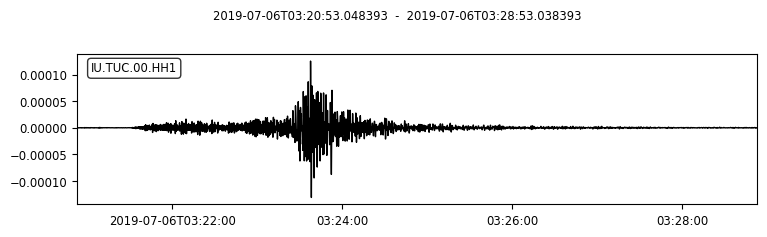

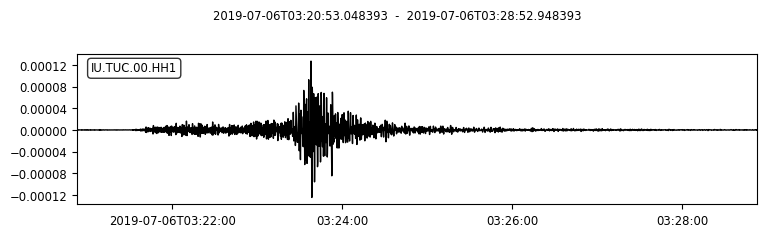

In [33]:
st_dec = st_trim.copy()

st_dec.decimate(10)

st_trim.plot()
st_dec.plot();

It doesn't look very different, but if we check the stats again, you can see the sampling rate is different! We could again save this as a new file if we want.

In [34]:
st_dec[0].stats.sampling_rate

10.0

This definitely doesn't cover all of the available methods for traces and streams - others that you might be interested in using include differentiate, integrate, stack, merge, sort, and many others. To see how to use these, check the Obspy documentation for streams and traces, which I linked at the beginning of this section, as there are lists and links to how to implement each of them!

## Matplotlib

Let's examine how we can make some basic plots of seismic data in [Matplotlib](https://matplotlib.org/), as there are many more customization options than just what you can do with st.plot().

The two basic things you need for any type of graph are an independent variable and a dependent variable. In our case, the independent variable would be our times in the timeseries, and the dependent variable is the actual ground velocity records. These two things are easy to parse from trace and stream objects - in fact, we already pulled out the data before in the very beginning of this notebook.

In [35]:
data = st[0].data

print(data)

[ -9.40377808e-07  -9.38652106e-07  -9.40177916e-07 ...,  -9.52581960e-07
  -1.10261625e-06  -9.28648806e-07]


Just as before, this pulls the data out into a Numpy array that can then be used for plotting.

Getting the times is slightly different, but also simple. This also operates on specific traces within streams, but instead, ["times"](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.times.html#obspy.core.trace.Trace.times) is actually a method instead of a property.

In [36]:
times = st[0].times()

print(times)

[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   9.59970000e+02
   9.59980000e+02   9.59990000e+02]


Because these both come from the same data trace, the arrays should be the same length, and we should be able to stick them in a Matplotlib plot easily.

In [37]:
print(len(data))
print(len(times))

96000
96000


Great! Let's try it out:

In [38]:
import matplotlib.pyplot as plt

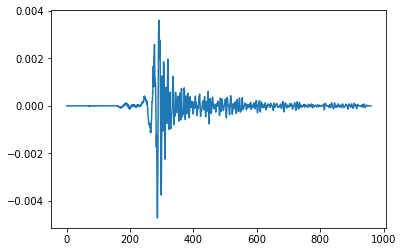

In [39]:
plt.plot(times, data);

And there we go! A very simple plot, and we can see that the data looks just like it did when we plotted using st.plot(). As anyone who is familiar with Matplotlib will know, there are a ton of different customization options you can use to make publication-quality plots. You can check out the documentation linked in the beginning of this section to learn more. Here is what I might do to clean up this basic plot a bit:

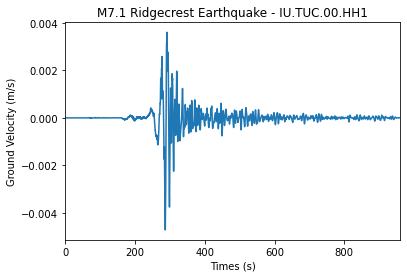

In [40]:
net = st[0].stats.network
sta = st[0].stats.station
loc = st[0].stats.location
chan = st[0].stats.channel

plt.plot(times, data)
plt.xlim(0,960)
plt.xlabel("Times (s)")
plt.ylabel("Ground Velocity (m/s)")
plt.title("M7.1 Ridgecrest Earthquake - " + net + "." + sta + "." + loc + "." + chan);

That looks pretty good! Something else you might want to do is plot the data from three channels from the same instrument at the same time. You can do this using subplots. 

To avoid confusion, let's just go back and re-download the data from this earthquake, and include all three channels. This code is copied from earlier in the notebook - the only difference is that I'll remove the response now from all three channels.

3 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples
IU.TUC.00.HH2 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples
IU.TUC.00.HHZ | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples


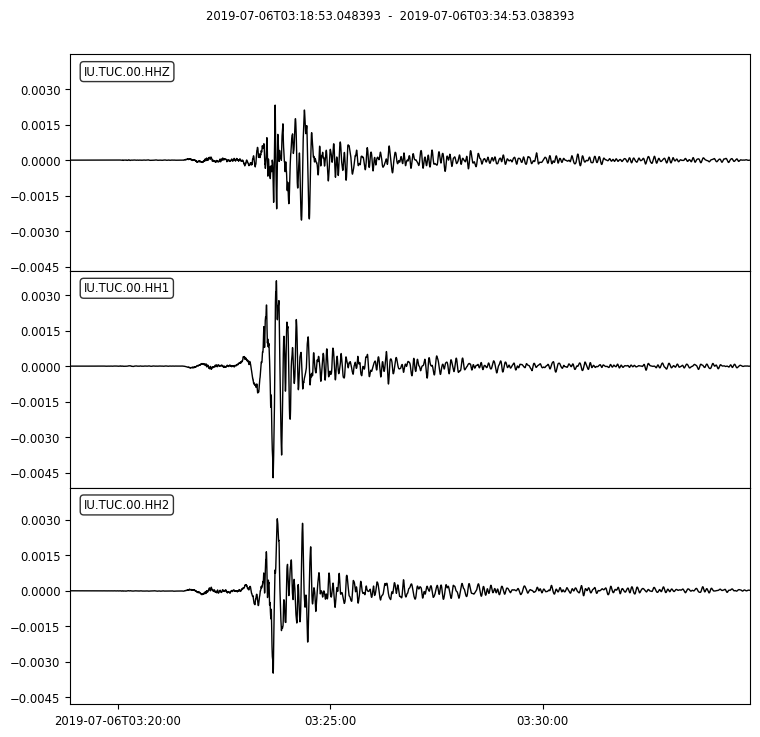

In [41]:
time = UTCDateTime("2019-07-06T03:19:53.04")
starttime = time - 60 
endtime = time + 60*15

net = "IU"
sta = "TUC"
loc = "00"
chan = "HH*"

st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
print(st)

st.remove_response(output = 'VEL')

st.plot();

Alright! Let's plot each of these three channels on their own subplots. First, we have to separate each trace's data and times out. If we plot them individually, we can visually see which trace in the stream corresponds to each channel.

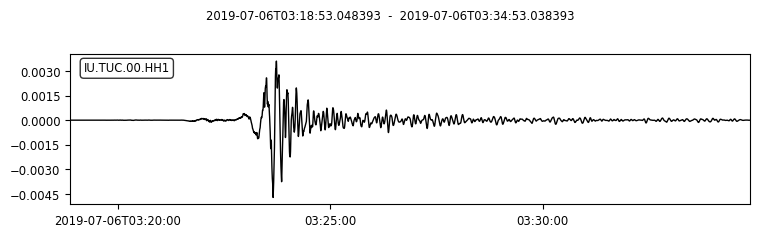

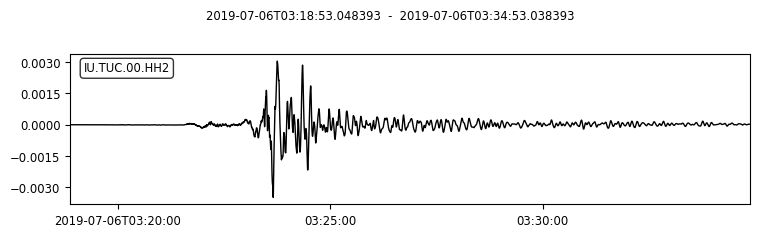

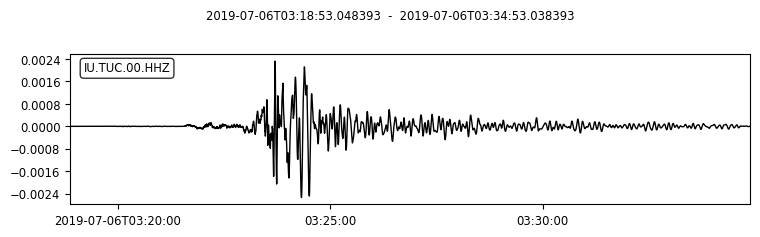

In [42]:
st[0].plot()
st[1].plot()
st[2].plot();

We can then define them as such.

In [43]:
HH1_data = st[0].data
HH1_times = st[0].times()

HH2_data = st[1].data
HH2_times = st[1].times()

HHZ_data = st[2].data
HHZ_times = st[2].times()

Now we can start plotting. We'll start by making a big "main" figure, and then we add subplots and the data to each of them.

In [44]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

To define subplots in Matplotlib, for each iteration you list the number of rows and number of columns you want, as well as which one you're on.

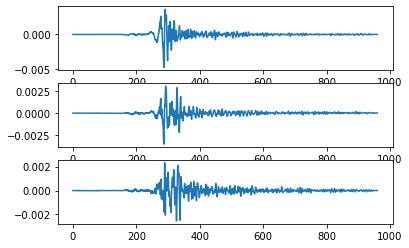

In [45]:
plt.subplot(311)
plt.plot(HH1_times, HH1_data)

plt.subplot(312)
plt.plot(HH2_times, HH2_data)

plt.subplot(313)
plt.plot(HHZ_times, HHZ_data);

Well, everything is there, but it sure looks squished! Let's try making the figure bigger. We can define a size in inches, with the width first and the height second.

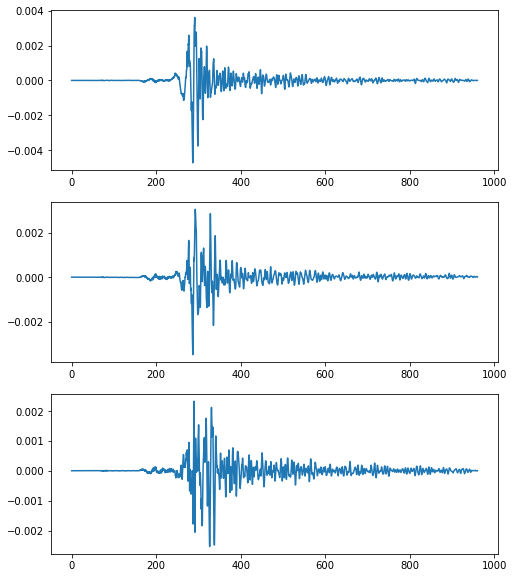

In [46]:
fig = plt.figure(figsize = (8,10))

plt.subplot(311)
plt.plot(HH1_times, HH1_data)

plt.subplot(312)
plt.plot(HH2_times, HH2_data)

plt.subplot(313)
plt.plot(HHZ_times, HHZ_data);

Great! Now let's clean it up with some labels, like we did last time. This time, we'll make it a little more complicated by adding a legend and channel labels, as well as changing the colors for each plot to make it easier to see.

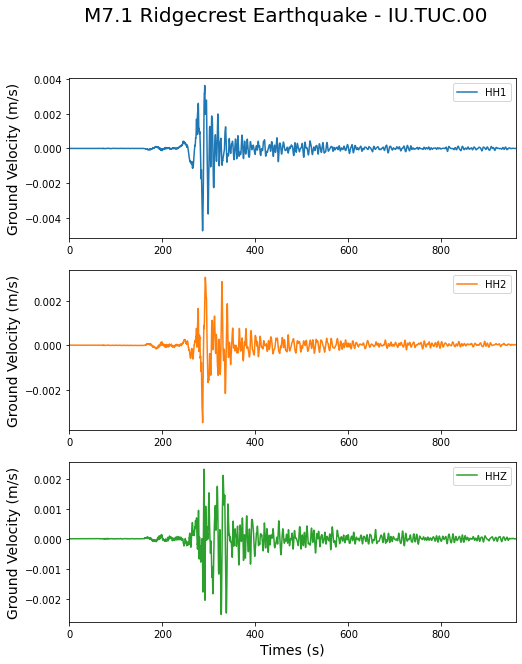

In [47]:
fig = plt.figure(figsize = (8,10))
plt.suptitle("M7.1 Ridgecrest Earthquake - " + net + "." + sta + "." + loc, fontsize = 20)

plt.subplot(311)
plt.plot(HH1_times, HH1_data, label = "HH1", color = 'C0')
plt.xlim(0,960)
plt.ylabel("Ground Velocity (m/s)", fontsize = 14)
plt.legend()

plt.subplot(312)
plt.plot(HH2_times, HH2_data, label = "HH2", color = 'C1')
plt.xlim(0,960)
plt.ylabel("Ground Velocity (m/s)", fontsize = 14)
plt.legend()

plt.subplot(313)
plt.plot(HHZ_times, HHZ_data, label = "HHZ", color = 'C2')
plt.xlim(0,960)
plt.xlabel("Times (s)", fontsize = 14)
plt.ylabel("Ground Velocity (m/s)", fontsize = 14)
plt.legend();

This looks pretty good! Other things I might consider changing would be to remove the ticks on the x-axis of the top two graphs and move the plots closer together, and make only one label for all of the subplots on the y-axis, but these are more advanced Matplotlib capabilities that you can look up and mess with. You can spend hours making plots look perfect!

Here is one final useful Matplotlib capability, with code provided by Liam Toney (who will be teaching the PyGMT tutorial): plotting so that you have your UTC times on the x-axis, rather than just seconds from zero, using [matplotlib.dates](https://matplotlib.org/api/dates_api.html).

In [48]:
import matplotlib.dates as mdates

We'll just demonstrate this on one channel - HH1. When we calculate the times this time, instead of leaving the parentheses blank, we specify the "type" of times as "matplotlib" so that we can plot them in UTC time.

In [49]:
chan = "HH1"

HH1_times_mpl = st[0].times(type = 'matplotlib')

Much of the plotting here is the same - it just incorporates another Matplotlib capability where you build your axes more manually. You can check out the documentation for this [here](https://matplotlib.org/api/axes_api.html). The basic plotting setup is as follows:

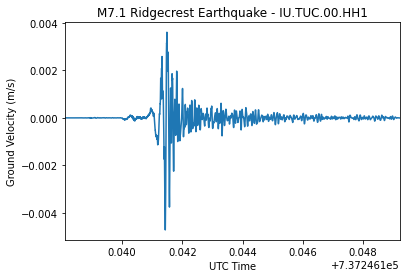

In [50]:
fig, ax = plt.subplots()

ax.plot(HH1_times_mpl, HH1_data)
ax.set_xlim(HH1_times_mpl[0], HH1_times_mpl[-1])
ax.set_xlabel("UTC Time")
ax.set_ylabel("Ground Velocity (m/s)")
ax.set_title("M7.1 Ridgecrest Earthquake - " + net + "." + sta + "." + loc + "." + chan);

Okay that's something! We just need to make the dates on the x-axis actually useful. We can do this with a locator. You can read more about this at the matplotlib.dates documentation linked above, but what this code does is allow Matplotlib to pick the best locations for the ticks on the x-axis and the best format for them. 

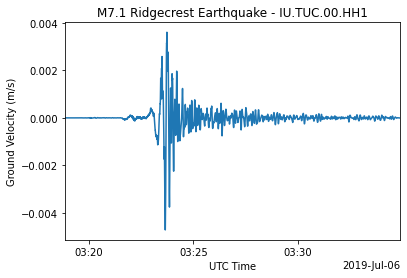

In [51]:
fig, ax = plt.subplots()

ax.plot(HH1_times_mpl, HH1_data)
ax.set_xlim(HH1_times_mpl[0], HH1_times_mpl[-1])
ax.set_xlabel("UTC Time")
ax.set_ylabel("Ground Velocity (m/s)")
ax.set_title("M7.1 Ridgecrest Earthquake - " + net + "." + sta + "." + loc + "." + chan);

locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

There we go!

I hope this notebook serves as a good introduction and starting point to working with seismic data in Obspy, and a resource for your future coding needs!